In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!nvidia-smi

Wed Dec  7 19:27:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.25       Driver Version: 522.25       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8     6W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing Dependencies

In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [4]:
import pickle
import glob
from PIL import Image

# Creating Test Dataloader

In [5]:
mean = 0.5199
std = 0.2488

# creating the train dataset and dataloader for calculating the mean and standard deviation of our samples
image_size = 64
batch_size = 4
CHANNELS_IMG = 1

stats = [mean for _ in range(CHANNELS_IMG)], [std for _ in range(CHANNELS_IMG)];stats

([0.5199], [0.2488])

In [6]:
class CustomDatasetWithPadding(Dataset):
    def __init__(self, data_dir, transforms):
        self.data = []
        self.transform = transforms
        self.targets = []
    
        class_list = os.listdir(data_dir) # ['Covid', 'Normal', 'Viral Pneumonia']
        for class_name in class_list:
            class_path = os.path.join(data_dir, class_name)
            for img_path in glob.glob(class_path + "/*.png"):
                self.data.append([img_path, class_name])
                
        self.available_classes = os.listdir(data_dir)
                        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = self.transform(Image.open(img_path))
        grey_image = np.zeros([1, 224, 224], dtype = np.float64)
        grey_image[:,80:144, 80:144] = img
        grey_image = torch.from_numpy(grey_image)
        grey_image = grey_image.type(torch.FloatTensor)
        # grey_image = grey_image.type(torch.cuda.FloatTensor)
        
        class_id = self.available_classes.index(class_name)
        class_id = torch.tensor(class_id)
        
        
        return grey_image, class_id

In [7]:
# following transformations will be performed on each image
transformations_to_perform = transform=tt.Compose([
                                tt.Grayscale(num_output_channels=1),
                                tt.Resize(image_size),
                                tt.ToTensor(),
                                tt.Normalize(*stats)])

val_data_dir = r'C:\Users\Lenovo\Desktop\FYP Coding\Covid-19 Dataset\Covid-19 Dataset\Validation'
test_data_dir = r'C:\Users\Lenovo\Desktop\FYP Coding\Covid-19 Dataset\Covid-19 Dataset\Test'


# Validation dataset
val_ds = CustomDatasetWithPadding(val_data_dir, transformations_to_perform)
val_dl = DataLoader(val_ds, batch_size, shuffle=True, pin_memory=True)

# Test dataset
test_ds = CustomDatasetWithPadding(test_data_dir, transformations_to_perform)
test_dl = DataLoader(test_ds, batch_size, shuffle=True, pin_memory=True)

# Using a GPU

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
# # transporting testing dataloaders to GPU

val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# Importing ResNet50 model and loading pretrained weights

In [11]:
# importing our custom ResNet-50 model

from ResNet50 import ResNet, block

In [12]:
img_channel = 1
num_classes = 3


model = ResNet(block, [3, 4, 6, 3], img_channel, num_classes)
model = to_device(model, device)

In [13]:
# Loading pretrained weights

model.load_state_dict(torch.load('ResNet_50_WGANGP.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

# Visualizing the models performance while Training

In [15]:
import copy
import copy
from matplotlib import rc, rcParams
rc('font', weight='bold')

In [16]:
with open('history_WGANGP.pkl', 'rb') as f:
      history = pickle.load(f)

In [17]:
history[0].keys()

dict_keys(['val_loss', 'val_acc'])

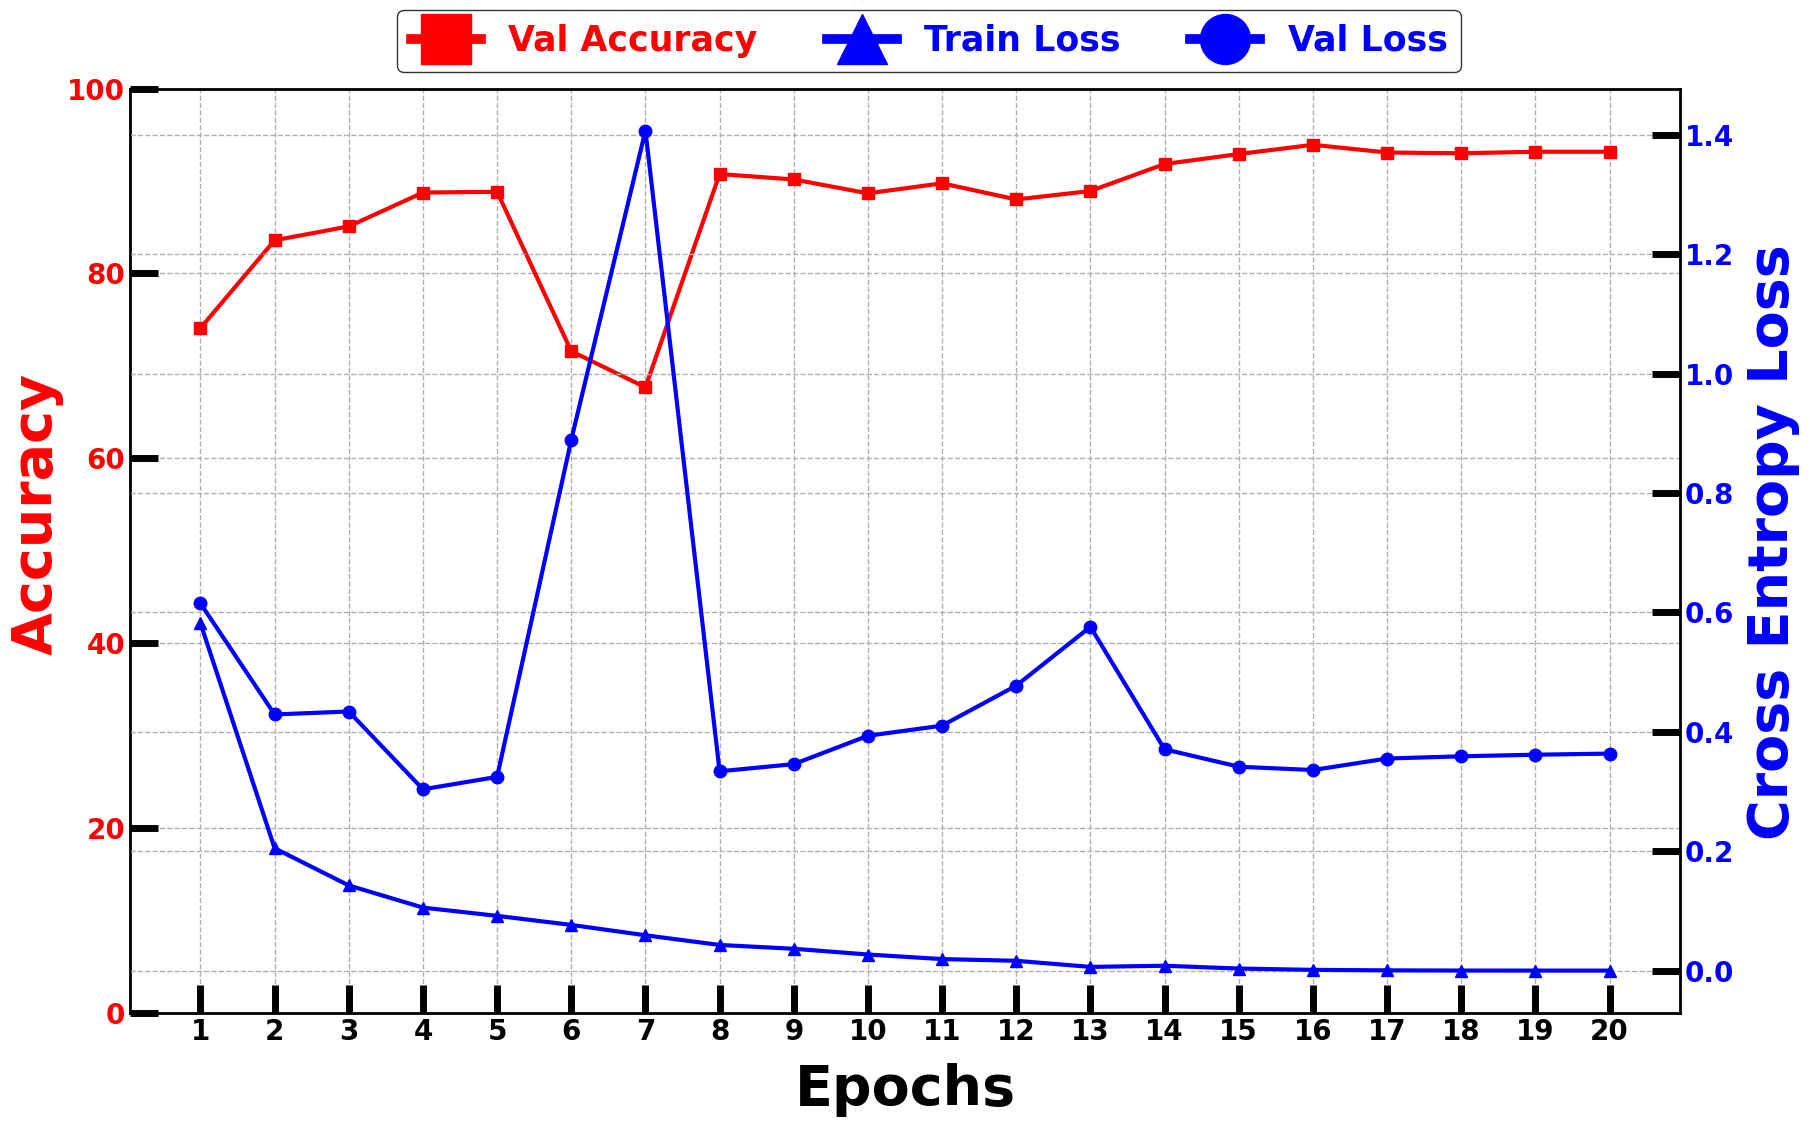

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(20, 12))

ax1 = plt.subplot(1,1,1)
plot_1 = ax1.plot(range(1, 21), [x['val_acc'] for x in history[1:]], color = 'red', label = 'Val Accuracy',\
                 marker = 's', linewidth=3.0, markersize = 9)

ax1.tick_params(axis ='y', labelcolor = 'red',labelsize=20, width=8) 
ax1.tick_params(axis ='x', labelcolor = 'black',labelsize=20, width=8)
ax1.set_ylim([0, 100])
# ax1.set_xlim([0,21])


ax1a = ax1.twinx()
plot_2 = ax1a.plot(range(1, 21), [x['train_loss'] for x in history[1:]], color = 'blue', label = 'Train Loss',\
                   marker = '^', linewidth=3.0, markersize = 9)

plot_3 = ax1a.plot(range(1, 21), [x['val_loss'] for x in history[1:]], color = 'blue', label = 'Val Loss',\
                   marker = 'o', linewidth=3.0, markersize = 9)

ax1a.tick_params(axis ='y', labelcolor = 'blue',labelsize=20, width=8) 


# set various colors
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_lw(2)



# for ax1 
ax1.tick_params(which='both', width=5)
ax1.tick_params(which='major', length=20)
ax1.tick_params(which='minor', length=5)
ax1.tick_params(which = 'both', direction = 'in')

# for ax1a
ax1a.tick_params(which='both', width=5)
ax1a.tick_params(which='major', length=20)
ax1a.tick_params(which='minor', length=5)
ax1a.tick_params(which = 'both', direction = 'in') 

ax1.grid(True, which = 'major', alpha = 1, linestyle='--', linewidth = 1)
ax1a.grid(True, which = 'major', alpha = 1, linestyle='--', linewidth = 1)


# Labels for legend
lns = plot_1 + plot_2+plot_3
labels = [l.get_label() for l in lns]
handles1, _ = ax1.get_legend_handles_labels()
handles2, _ = ax1a.get_legend_handles_labels()
handles = handles1 + handles2
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(7) for ha in handles ]
leg = fig.legend(lns, labels, handles = handles,loc="upper left", bbox_to_anchor=(0.25,0.96),\
           fontsize = 25, ncol=3, markerscale=4, labelcolor='linecolor')
leg.get_frame().set_edgecolor('black')


ax1.text(-0.06, 0.4, 'Accuracy',horizontalalignment='center',transform=ax1.transAxes, \
         fontsize = 40, fontweight="bold", rotation = 'vertical', color = 'red')
ax1a.text(1.06, 0.2, 'Cross Entropy Loss',horizontalalignment='center',transform=ax1a.transAxes, \
         fontsize = 40, fontweight="bold", rotation = 'vertical', color = 'blue')
ax1a.text(0.5, -0.1, 'Epochs', horizontalalignment='center',transform=ax1a.transAxes, \
         fontsize = 40, fontweight="bold", rotation = 'horizontal', color = 'black')

ticks = range(1, 21)
new_xticks = [str(i) for i in range(1, 21)]
plt.xticks(ticks, new_xticks, fontsize =30);
# fig.savefig("ResNet50_Imbalanced_Training_Performance.jpg")

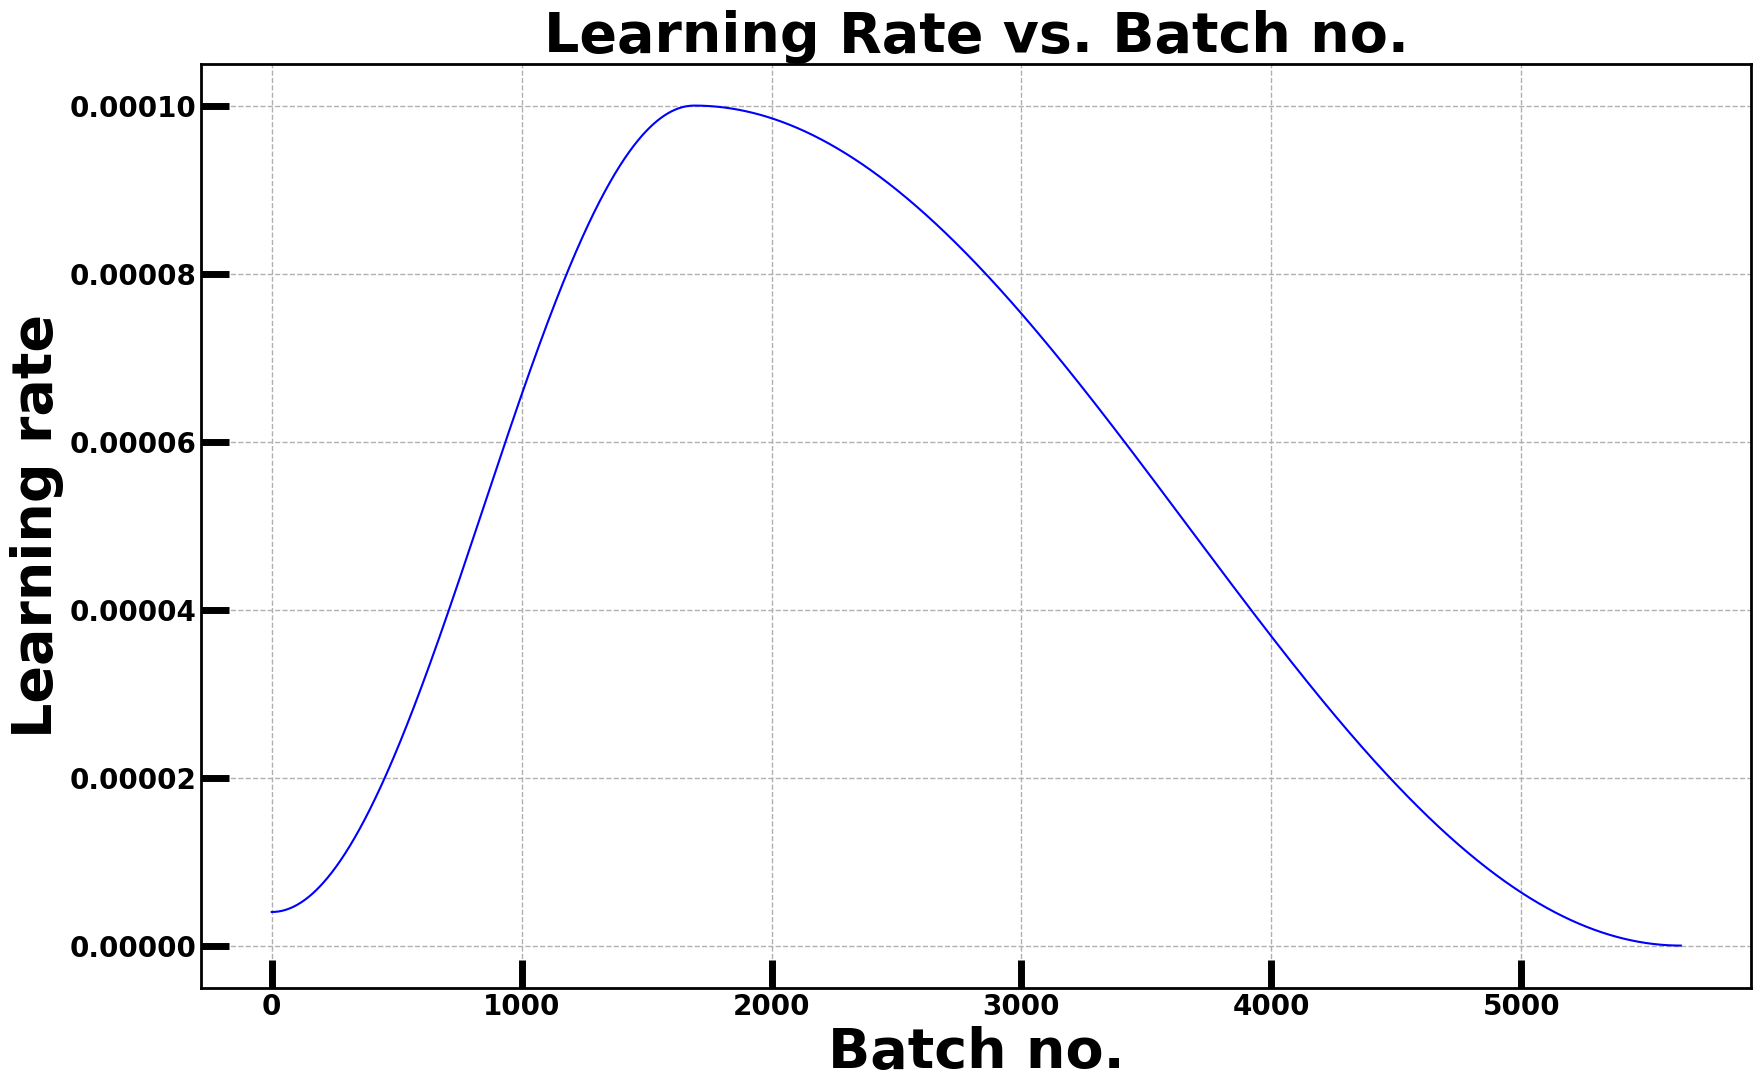

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(20, 12))

ax1 = plt.subplot(1,1,1)
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.plot(lrs, color = 'blue')
plt.xlabel('Batch no.', fontweight = 'bold', fontsize = 40)
plt.ylabel('Learning rate', fontweight = 'bold', fontsize = 40)
plt.title('Learning Rate vs. Batch no.', fontweight = 'bold', fontsize = 40)
ax1.tick_params(axis ='y', labelcolor = 'black',labelsize=20, width=8) 
ax1.tick_params(axis ='x', labelcolor = 'black',labelsize=20, width=8)

# set various colors
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_lw(2)



# for ax1 
ax1.tick_params(which='both', width=5)
ax1.tick_params(which='major', length=20)
ax1.tick_params(which='minor', length=5)
ax1.tick_params(which = 'both', direction = 'in')
 

ax1.grid(True, which = 'major', alpha = 1, linestyle='--', linewidth = 1);
# fig.savefig("ResNet50_Imbalanced_Training_Performance_lr_vs_batches.jpg")

# Checking performance on Test set

In [14]:
from tqdm import tqdm

In [15]:
actual_labels = []
predicted_probabilities = []
predicted_labels = []
predicted_probabilities_for_each_class = []

for images, labels in tqdm(test_dl):
   
    # make predictions
    yb = model(images)
    
    out = nn.Softmax(dim = 1)(yb)
    out = out.cpu()
        
    # Pick index with highest probability
    probabilities, preds  = torch.max(out, dim=1)
#     print(out)
    
    predicted_probabilities_for_each_class_local = list(np.array(out.detach()))
    probabilities = probabilities.cpu()
    preds = list(np.array(preds))
    probabilities = list(np.array(probabilities.detach()))
    
    actual_labels.append(list(np.array(labels.cpu())))
    predicted_probabilities.append(probabilities)
    predicted_labels.append(preds)
    predicted_probabilities_for_each_class.append(predicted_probabilities_for_each_class_local)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 28.50it/s]


In [16]:
predicted_labels = np.array(predicted_labels, dtype = int).reshape(-1)
actual_labels = np.array(actual_labels, dtype = int).reshape(-1)

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
print("The testing accuracy is: {}".format(accuracy_score(actual_labels, predicted_labels)*100,\
                                           3))

The testing accuracy is: 93.25


In [19]:
predicted_probabilities_for_each_class = np.array([np.array([j.tolist() for j in i]) for i in predicted_probabilities_for_each_class])
predicted_probabilities_for_each_class = predicted_probabilities_for_each_class.reshape(1200, 3)

In [20]:
from sklearn.metrics import classification_report, roc_auc_score

In [21]:
print("TEST\n")
print(classification_report(actual_labels, predicted_labels))

TEST

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       400
           1       0.88      0.96      0.92       400
           2       0.97      0.89      0.92       400

    accuracy                           0.93      1200
   macro avg       0.94      0.93      0.93      1200
weighted avg       0.94      0.93      0.93      1200



# Custom function

In [22]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from matplotlib import rc, rcParams
rc('font', weight='bold')

In [23]:
classes = ['Covid', 'Normal', 'Viral Pneumonia']

In [24]:
cf_matrix = confusion_matrix(actual_labels, predicted_labels)
dataframe = pd.DataFrame(cf_matrix, index = classes, columns = classes)

In [25]:
import pickle

with open('CM_ResNet50_WGANGPAug.pkl', 'wb') as f:
       pickle.dump(dataframe, f)

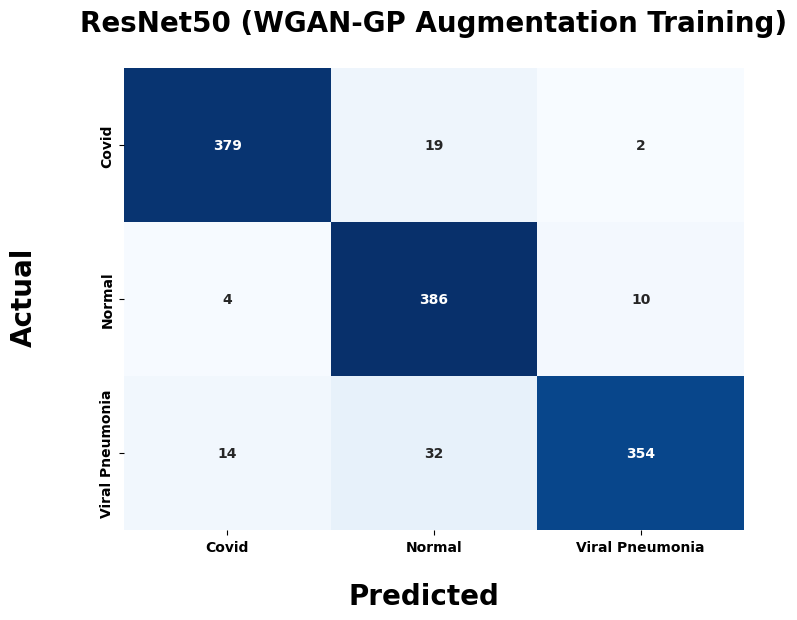

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

ax1 = plt.subplot(1, 1, 1)

sns.heatmap(dataframe, cmap="Blues", annot = True, fmt="d", cbar =False)
fig.text(0.5, 0.00, 'Predicted', ha='center', va='center', fontsize = 20)
fig.text(0.0, 0.5, 'Actual', ha='center', va='center', rotation='vertical', fontsize = 20)
ax1.text(0.5, 1.08, 'ResNet50 (WGAN-GP Augmentation Training)',
    horizontalalignment='center',
    fontsize=20,
    transform = ax1.transAxes);

In [26]:
metrics_df = pd.DataFrame({'Model': [], 'Train_Condition': [],'Class' : [],'TP': [], 'FP': [], 'FN': [],'TN':[], 'Recall': [],'Precision': [],\
                           'Specificity': [],'FPR': [], 'FNR': [], 'f1_score': [], 'Accuracy': [], 'AUC': []})

hold_fprs_tprs_df = pd.DataFrame({'Model': [], 'Train_Condition': [], 'Class': [],'fprs': [], 'tprs': []})

metrics_df_columns = metrics_df.columns

In [27]:
from sklearn.metrics import accuracy_score, roc_curve

In [29]:
def metrics(cm, targets, preds, predicted_probabilities, model_name):
    # for class Covid
    TP_Covid = cm[0][0]
    TN_Covid = sum(cm[1][1:]) + sum(cm[2][1:])
    FP_Covid = cm[1][0] + cm[2][0]
    FN_Covid = cm[0][1] + cm[0][2]
    
    # for class Normal
    TP_Normal = cm[1][1]
    TN_Normal = cm[0][1] + cm[0][2] + cm[2][0] + cm[2][2]
    FP_Normal = cm[0][1] + cm[2][1]
    FN_Normal = cm[1][0] + cm[1][2]
    
    # for class ViralPneumonia
    TP_ViralPneumonia = cm[2][2]
    TN_ViralPneumonia = cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1]
    FP_ViralPneumonia = cm[0][2] + cm[1][2]
    FN_ViralPneumonia = cm[2][0] + cm[2][1]
    
    # precision
    precision_class_0 = round(TP_Covid / (TP_Covid + FP_Covid), 4)
    precision_class_1 = round(TP_Normal / (TP_Normal + FP_Normal), 4)
    precision_class_2 = round(TP_ViralPneumonia / (TP_ViralPneumonia + FP_ViralPneumonia), 4)
    
    
    # Recall / FPR / Sensitivity
    recall_class_0 = round(TP_Covid / (TP_Covid + FN_Covid), 4)
    recall_class_1 = round(TP_Normal / (TP_Normal + FN_Normal), 4)
    recall_class_2 = round(TP_ViralPneumonia / (TP_ViralPneumonia + FN_ViralPneumonia), 4)
    
    # F1 Score
    f1_score_class_0 = round(2 * (recall_class_0 * precision_class_0) / (recall_class_0 + precision_class_0), 4)
    f1_score_class_1 = round(2 * (recall_class_1 * precision_class_1) / (recall_class_1 + precision_class_1), 4)
    f1_score_class_2 = round(2 * (recall_class_2 * precision_class_2) / (recall_class_2 + precision_class_2), 4)
    
    # Specificity / True Negative Rate
    specificity_class_0 = round(TN_Covid / (TN_Covid + FP_Covid), 4)
    specificity_class_1 = round(TN_Normal / (TN_Normal + FP_Normal), 4)
    specificity_class_2 = round(TN_ViralPneumonia / (TN_ViralPneumonia + FP_ViralPneumonia), 4)
    
    # False Positive Rate
    fpr_class_0 = round(FP_Covid / (FP_Covid + TN_Covid), 4)
    fpr_class_1 = round(FP_Normal / (FP_Normal + TN_Normal), 4)
    fpr_class_2 = round(FP_ViralPneumonia / (FP_ViralPneumonia + TN_ViralPneumonia), 4)
    
    
    # False Negative Rate
    fnr_class_0 =  round(FN_Covid / (FN_Covid + TP_Covid), 4)
    fnr_class_1 =  round(FN_Normal / (FN_Normal + TP_Normal), 4)
    fnr_class_2 =  round(FN_ViralPneumonia / (FN_ViralPneumonia + TP_ViralPneumonia), 4)

    # Calculating False positive rates and True Positive Rates
    fprs = {}
    tprs = {}
    thresholds ={}

    for i in range(3):    
        fprs[i], tprs[i], thresholds[i] = roc_curve(targets, predicted_probabilities[:,i], pos_label=i)
        
        
#     auc_score_ovr = round(roc_auc_score(targets, predicted_probabilities, multi_class='ovr'), 4)
    auc_score_ovr = roc_auc_score(actual_labels, predicted_probabilities_for_each_class, multi_class='ovr', average = None)
    auc_score_ovr = [round(i, 4) for i in auc_score_ovr]
    
    accuracy =  round(accuracy_score(targets, preds), 4)
    

    array_0 = np.array([model_name, 'WGANGP Augmentation','Covid',TP_Covid, FP_Covid, FN_Covid, TN_Covid, recall_class_0, precision_class_0, \
                        specificity_class_0, fpr_class_0, fnr_class_0, f1_score_class_0, \
                        accuracy, auc_score_ovr[0]])
    
    array_1 = np.array([model_name, 'WGANGP Augmentation', 'Normal',TP_Normal, FP_Normal, FN_Normal, TN_Normal, recall_class_1, precision_class_1, \
                    specificity_class_1, fpr_class_1, fnr_class_1, f1_score_class_1, \
                    accuracy, auc_score_ovr[1]])
        
    array_2 = np.array([model_name, 'WGANGP Augmentation','Viral Pneumonia',TP_ViralPneumonia, FP_ViralPneumonia, FN_ViralPneumonia, TN_ViralPneumonia, \
                        recall_class_2, precision_class_2, specificity_class_2, fpr_class_2, \
                        fnr_class_2, f1_score_class_2, accuracy, auc_score_ovr[2]])
    
    
    arr_0 = [[model_name for i in range(len(fprs[0]))], ['WGANGP Augmentation' for i in range(len(fprs[0]))], \
             ['Covid' for i in range(len(fprs[0]))], fprs[0], tprs[0]]
    arr_0 = pd.DataFrame(arr_0).T 
    
    arr_1 = [[model_name for i in range(len(fprs[1]))], ['WGANGP Augmentation' for i in range(len(fprs[1]))], \
             ['Normal' for i in range(len(fprs[1]))], fprs[1], tprs[1]]
    arr_1 = pd.DataFrame(arr_1).T
    
    
    arr_2 = [[model_name for i in range(len(fprs[2]))], ['WGANGP Augmentation' for i in range(len(fprs[2]))], \
             ['Viral Pneumonia' for i in range(len(fprs[2]))], fprs[2], tprs[2]]
    arr_2 = pd.DataFrame(arr_2).T
    
    
    arr_123 = pd.concat([arr_0, arr_1, arr_2]).reset_index(drop = True)
    arr_123.columns = hold_fprs_tprs_df.columns
    
    
    temp = pd.DataFrame(array_0).T
    temp.columns = metrics_df_columns
    temp.loc[1] = array_1
    temp.loc[2] = array_2
    
    return arr_123, temp

In [30]:
arr_123, temp = metrics(cf_matrix, actual_labels, predicted_labels, predicted_probabilities_for_each_class, 'ResNet50')

In [31]:
arr_123

,Model,Train_Condition,Class,fprs,tprs
0,ResNet50,WGANGP Augmentation,Covid,0.0,0.0
1,ResNet50,WGANGP Augmentation,Covid,0.0,0.015
2,ResNet50,WGANGP Augmentation,Covid,0.0,0.0375
3,ResNet50,WGANGP Augmentation,Covid,0.0,0.0575
4,ResNet50,WGANGP Augmentation,Covid,0.0,0.0675
...,...,...,...,...,...
399,ResNet50,WGANGP Augmentation,Viral Pneumonia,0.73375,1.0
400,ResNet50,WGANGP Augmentation,Viral Pneumonia,0.73625,1.0
401,ResNet50,WGANGP Augmentation,Viral Pneumonia,0.85375,1.0
402,ResNet50,WGANGP Augmentation,Viral Pneumonia,0.85625,1.0


In [32]:
arr_123.to_csv('ResNet50_WGANGPAug_Fprs_Tprs.csv', index = True)

In [34]:
temp.to_csv('ResNet50_WGANGPAug_metrics.csv', index = True)